In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np 
import torch.nn.functional as F
from torch import nn
from torch import optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader,TensorDataset,SubsetRandomSampler
import scanpy as sc

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

In [2]:
moudata = np.load('5 x_mou_0831_anno.npz', allow_pickle=True)
x_mou = torch.from_numpy(moudata['x'].astype(np.float32))
y_mou = torch.from_numpy(moudata['y'].astype(np.int32))
y_mou = y_mou.long() - 1
dataset = TensorDataset(x_mou, y_mou)

#x_bin = (x_mou>0)*1
#x_bin = x_bin.float()
#dataset = TensorDataset(x_bin, y_mou)

inputSize = x_mou.shape[1]
outputSize = 14

In [3]:
class MLR(nn.Module):
    def __init__(self):
        super(MLR, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, outputSize)
        )
            
    def forward(self, x):
        out = self.layers(x)
        if not self.training:
            #print("TESTING MODE")
            out = F.softmax(out, dim=1)
        #out = out.view(out.shape[0], -1)
        return out

In [4]:
device = "cuda:0"
torch.manual_seed(42)
num_epochs = 20
batch_size = 64
k = 5
splits = KFold(n_splits = k, shuffle=True, random_state=42)
loss_fn = nn.CrossEntropyLoss()
foldperf={}

In [5]:
def train(model, device, train_idx, loss_fn, optimizer):
    train_loss, train_correct=0.0,0
    model.train()

    x_train = x_mou[train_idx]
    y_train = y_mou[train_idx]

    for i in range(42):
        sample_idx=[]
        for t in np.unique(y_train):
            t_idx = np.where(y_train==t)[0]
            sample_idx.append(np.random.choice(t_idx, size=5))
        sample_idx = np.vstack(sample_idx)
        sample_idx = sample_idx.reshape(sample_idx.size)
        x_sample = x_train[sample_idx]
        y_sample = y_train[sample_idx]

        inputs,labels = x_sample.to(device), y_sample.to(device)
        optimizer.zero_grad()
        output = model(inputs.float())

        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

def val(model, device, val_idx, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()

    x_test = x_mou[val_idx]
    y_test = y_mou[val_idx]

    inputs,labels = x_test.to(device),y_test.to(device)
    output = model(inputs)
    loss = loss_fn(output,labels)
    valid_loss += loss.item()*inputs.size(0)
    scores, predictions = torch.max(output.data,1)
    val_correct += (predictions == labels).sum().item()

    return valid_loss,val_correct

In [6]:
for fold, (train_idx,val_idx) in enumerate(splits.split(x_mou,y_mou)):
    torch.cuda.empty_cache()
    print('Fold {}'.format(fold + 1))

    x_train = x_mou[train_idx]
    y_train = y_mou[train_idx]
    train_set = TensorDataset(x_train, y_train)

    x_test = x_mou[val_idx]
    y_test = y_mou[val_idx]
    test_set = TensorDataset(x_train, y_train)
    
    model = MLR()
    model.to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=0.001)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct = train(model, device, train_idx, loss_fn, optimizer)
        test_loss, test_correct = val(model, device, val_idx, loss_fn)

        train_acc = train_correct / (70*42) * 100
        test_acc = test_correct / len(val_idx) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(
            epoch + 1, num_epochs, train_loss, test_loss, train_acc, test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

Fold 1
Epoch:1/20 AVG Training Loss:868.262 AVG Test Loss:2042.084 AVG Training Acc 91.26 % AVG Test Acc 93.56 %
Epoch:2/20 AVG Training Loss:154.167 AVG Test Loss:2022.518 AVG Training Acc 98.40 % AVG Test Acc 94.20 %
Epoch:3/20 AVG Training Loss:73.358 AVG Test Loss:2022.317 AVG Training Acc 99.42 % AVG Test Acc 93.65 %
Epoch:4/20 AVG Training Loss:33.062 AVG Test Loss:2016.848 AVG Training Acc 99.73 % AVG Test Acc 94.65 %
Epoch:5/20 AVG Training Loss:19.763 AVG Test Loss:2012.982 AVG Training Acc 99.86 % AVG Test Acc 94.47 %
Epoch:6/20 AVG Training Loss:10.195 AVG Test Loss:2011.619 AVG Training Acc 99.93 % AVG Test Acc 94.56 %
Epoch:7/20 AVG Training Loss:5.572 AVG Test Loss:2009.368 AVG Training Acc 100.00 % AVG Test Acc 94.74 %
Epoch:8/20 AVG Training Loss:19.219 AVG Test Loss:2007.016 AVG Training Acc 99.93 % AVG Test Acc 94.92 %
Epoch:9/20 AVG Training Loss:8.013 AVG Test Loss:2006.011 AVG Training Acc 99.93 % AVG Test Acc 94.83 %
Epoch:10/20 AVG Training Loss:4.823 AVG Test Lo

In [7]:
#torch.save(model,'MLR-binary_0828.pt')
torch.save(model,'MLR_0912_equalSample.pt')

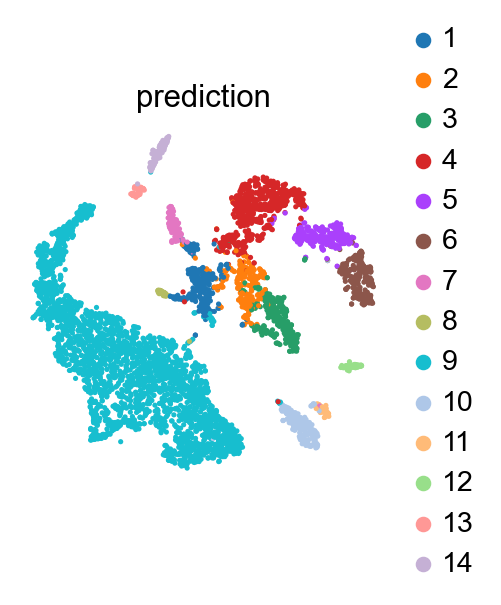

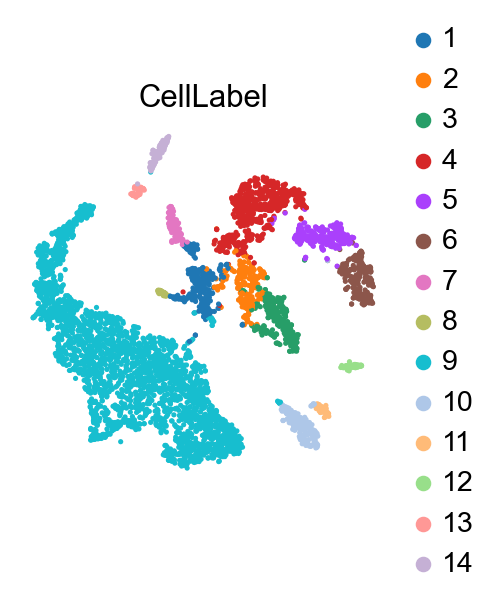

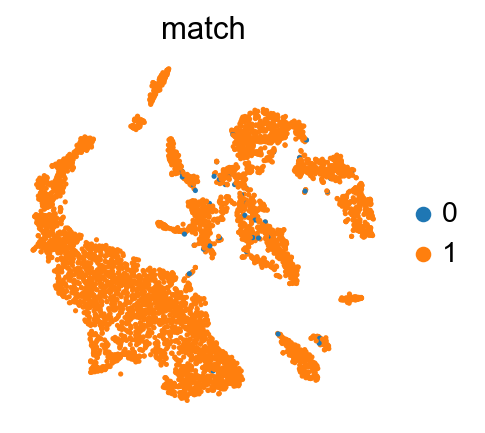

0.9898403483309144

In [8]:
adata = sc.read_h5ad('3 clustered_mou_0831_anno.h5ad')
v,p = torch.max(model(x_mou.to(device)),1)
adata.obs['prediction'] = p.cpu().detach().numpy() + 1
adata.obs = adata.obs.astype({'prediction': 'category'})
adata.obs['match'] = ((adata.obs['prediction'] == adata.obs['CellLabel'])*1).astype('category')
sc.pl.tsne(adata,color='prediction')
sc.pl.tsne(adata,color='CellLabel')
sc.pl.tsne(adata,color='match')

np.sum(adata.obs['match'].astype('int64'))/adata.obs['match'].shape[0]